In [62]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, join_meshes_as_scene, join_meshes_as_batch
from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt
import matplotlib as mpl
import pytorch3d

In [7]:
# Set the device
if torch.cuda.is_available():
	device = torch.device("cuda:0")
else:
	device = torch.device("cpu")
	print("WARNING: CPU only, this will be slow!")


### Get all mesh files

In [14]:
folder_path = '../meshes/collision-obj'

# Get all files in the folder
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

In [16]:
verts_list = []
faces_list = []
aux_list = []
for file in files:
	verts, faces, aux = load_obj(file)
	verts_list.append(verts)
	faces_list.append(faces)
	aux_list.append(aux)


An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/sscekic/anaconda3/envs/nerf/lib/python3.12/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/sscekic/anaconda3/envs/nerf/lib/python3.12/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
        ^^^^^^^^^
AttributeError: 'NativePathHandler' object has no attribute '_evt'
/home/sscekic/anaconda3/envs/nerf/lib/python3.12/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/sscekic/anaconda3/envs/nerf/lib/python3.12/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/sscekic/anaconda3/envs/nerf/l

### Construct meshes

In [19]:
meshes = []
for i in range(len(verts_list)):
	faces_idx = faces_list[i].verts_idx
	verts = verts_list[i]

	meshes.append(Meshes(verts=[verts], faces=[faces_idx]))


In [74]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

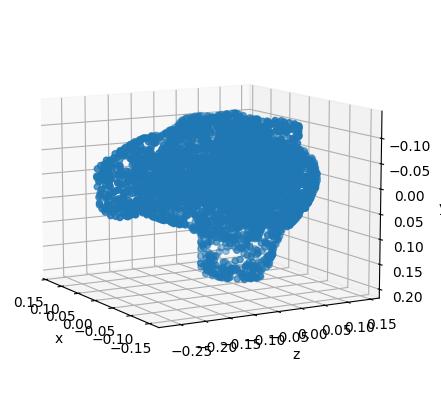

In [75]:
mesh = join_meshes_as_scene(meshes)
plot_pointcloud(mesh)